In [80]:
from sklearn.svm import SVC,NuSVC, SVR, LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline,make_pipeline
import numpy as np
import pandas as pd
from q_value_calc_crosslinks import readAndProcessIdXML, calcQ
import matplotlib.pyplot as plt
import re

In [81]:
input_file_perc = "../data/crosslink_data/AChernev_080219_HeLa_RNA_UV_opti_.idXML"
input_file = "../data/crosslink_data/AChernev_080219_HeLa_RNA_UV.idXML"

In [82]:
features = ['Score','peplen', 'NuXL:isXL', 'NuXL:modds', 'NuXL:pl_modds', 
                'NuXL:mass_error_p', 'NuXL:tag_XLed', 'NuXL:tag_unshifted' ,
                'NuXL:tag_shifted', 'missed_cleavages', 'NuXL:ladder_score',
                'variable_modifications']
scaling = ['Score', 'peplen', 'NuXL:isXL', 'NuXL:modds', 'NuXL:pl_modds', 
                'NuXL:mass_error_p', 'NuXL:tag_XLed', 'NuXL:tag_unshifted' ,
                'NuXL:tag_shifted', 'missed_cleavages', 'NuXL:ladder_score',
                'variable_modifications']

# read data
original_df = readAndProcessIdXML(input_file)
q_vals_before = calcQ(original_df)
perc_df = readAndProcessIdXML(input_file_perc)
#perc_df = perc_df.loc[perc_df['rank'] == 0,:]
q_vals_perc = calcQ(perc_df)

# filter data and sort according to score
df = original_df.filter(np.concatenate([features,['rank', 'Label']]))
df = df.sort_values('Score',ascending=False)

c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [83]:
# determine minority class 
minority_class = min({df.loc[df['NuXL:isXL'] == 0].size, df.loc[df['NuXL:isXL'] == 1].size})
class_threshold = 500
if (minority_class > class_threshold): minority_class = class_threshold
# define training data (peptides with top and bottom scores of each class with rank 0)
pep_top = df.loc[(df['NuXL:isXL'] == 0) & (df['rank'] == 0)][:int(minority_class/2)]
pep_bottom = df.loc[(df['NuXL:isXL'] == 0) & (df['rank'] == 0)][-int(minority_class/2):]
XL_top = df.loc[(df['NuXL:isXL'] == 1) & (df['rank'] == 0)][:int(minority_class/2)]
XL_bottom = df.loc[(df['NuXL:isXL'] == 1) & (df['rank'] == 0)][-int(minority_class/2):]
train_idx = np.concatenate([pep_top.index, pep_bottom.index, XL_top.index, XL_bottom.index])

In [84]:
labels = np.empty(len(df))
labels[pep_bottom.index] = 0
labels[XL_bottom.index] = 0
labels[pep_top.index] = 1
labels[XL_top.index] = 1

In [85]:
X_train = df.loc[train_idx,features]
y_train = labels[train_idx]
X = df.loc[:,features]

In [ ]:
# initialise the k-fold cross validator
no_split = 10
kf = KFold(n_splits=no_split, shuffle=True, random_state=42)

param_grid = {
        'C': np.power(float(2), [-5,-1,1,5,7,11,15]),
        #'epsilon': np.power(float(2), [-15,-9,-6,-3.32192809489,0,3.32192809489,6,9,15])
    }
# create the pipeline
pipe = make_pipeline(MinMaxScaler(), 
                        GridSearchCV(
                            estimator=SVC(kernel='linear', probability=True), 
                            param_grid=param_grid, 
                            n_jobs=-1,
                            scoring="accuracy",
                            cv=kf, 
                            refit=True))
pipe.fit(X_train, y_train)
probabilities = pipe.predict_proba(X.loc[:,features])
new_scores = original_df.copy()
new_scores['Score'] = probabilities[:,1]
q_vals_after = calcQ(new_scores)

c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


In [87]:
def get_target_id(
    scores: pd.DataFrame,                   # pd.DataFrame: Input data containing PSMs and q-values
    isXLColName: str = "NuXL:isXL",           # str: Column name indicating if the peptide is crosslinked
    label_col: str = "Label",              # str: Column name for the label, indicating target (1) or decoy
    q_val_col: str = "class-specific_q-val",
    max_qvalue: float = 0.1
):
    scores.sort_values("Score",ascending=False,inplace=True)
    # Initialize a dictionary to store counts of PSMs below each q-value threshold
    result = []
    for XL in [0,1]:
        XL_summary_q_val_count = []
        
        # Filter for crosslinked (XL) PSMs
        XL_psms_q_df = scores[scores[isXLColName] == XL]
        XL_psms_q_df.sort_values(['class-specific_q-val', 'Score'], ascending=[True, False], inplace=True)

        XL_q_value_thresholds = XL_psms_q_df[q_val_col]

        # Further filter to keep only target PSMs (label == 1)
        XL_psms_q_df = XL_psms_q_df[XL_psms_q_df[label_col] == 1]
        # Count the number of PSMs below each q-value threshold
        for qvalue in XL_q_value_thresholds:
            # Count XL PSMs below the class-specific q-value threshold
            XL_summary_q_val_count.append(sum(j < min(qvalue, max_qvalue) for j in XL_psms_q_df[q_val_col]))
        result.append(XL_q_value_thresholds)
        result.append(XL_summary_q_val_count)

    return result

pep_q_value_thresholds_after, pep_target_id_after, XL_q_value_thresholds_after, XL_target_id_after = get_target_id(q_vals_after)
pep_q_value_thresholds_before, pep_target_id_before, XL_q_value_thresholds_before, XL_target_id_before  = get_target_id(q_vals_before)
pep_q_value_thresholds_perc, pep_target_id_perc, XL_q_value_thresholds_perc, XL_target_id_perc = get_target_id(q_vals_perc)

C:\Users\mail\AppData\Local\Temp\ipykernel_22584\3531029102.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XL_psms_q_df.sort_values(['class-specific_q-val', 'Score'], ascending=[True, False], inplace=True)


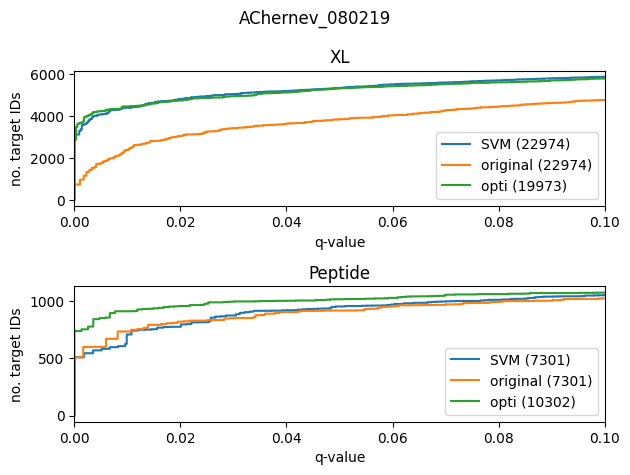

In [88]:
fig, axs = plt.subplots(2)
axs[0].step(XL_q_value_thresholds_after,XL_target_id_after, label=f"SVM ({len(XL_q_value_thresholds_after)})" )
axs[1].step(pep_q_value_thresholds_after,pep_target_id_after, label=f"SVM ({len(pep_q_value_thresholds_after)})")
axs[0].step(XL_q_value_thresholds_before,XL_target_id_before, label=f"original ({len(XL_q_value_thresholds_before)})" )
axs[1].step(pep_q_value_thresholds_before,pep_target_id_before, label = f"original ({len(pep_q_value_thresholds_before)})")
axs[0].step(XL_q_value_thresholds_perc,XL_target_id_perc, label=f"opti ({len(XL_q_value_thresholds_perc)})")
axs[1].step(pep_q_value_thresholds_perc,pep_target_id_perc, label=f"opti ({len(pep_q_value_thresholds_perc)})")
axs[0].set_xlim(0,0.1)
axs[1].set_xlim(0,0.1)
axs[0].set_title("XL")
axs[1].set_title("Peptide")
axs[0].set_xlabel("q-value")
axs[1].set_xlabel("q-value")
axs[0].set_ylabel("no. target IDs")
axs[1].set_ylabel("no. target IDs")
axs[0].legend()
axs[1].legend()
str_title = re.search("_data/.*_(Expl|HeLa)", input_file).group()[6:-5]
fig.suptitle(str_title)
fig.tight_layout()
plt.show()